In [1]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import cm
from matplotlib.collections import LineCollection
import matplotlib

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
from scipy.interpolate import interpn

#from mpl_toolkits.basemap import Basemap
import math
import warnings
%matplotlib inline
import xarray as xr
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')

from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
#dg = xr.open_dataset('/scratch/project_2000789/boeiradi/waom10_frc/waom10extend_grd.nc')
dg = xr.open_dataset('/scratch/project_2000789/boeiradi/waom4_frc/waom4extend_grd.nc')
#ds = xr.open_dataset('/scratch/project_2000789/boeiradi/waom10extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0016.nc')
ds = xr.open_dataset('/scratch/project_2000789/boeiradi/waom4extend_shflim_S_0.25Q/output_yr10_diag/sfc_fluxes_anual.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 73, eta_rho: 1400, xi_rho: 1575)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2016-01-01T12:00:00 ... 2016-12-3...
    x_rho       (eta_rho, xi_rho) float64 ...
    y_rho       (eta_rho, xi_rho) float64 ...
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    shflux      (ocean_time, eta_rho, xi_rho) float32 ...
    ssflux      (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/35)
    file:              /scratch/project_2002875/boeiradi/waom4extend_shflim_S...
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4
    type:              ROMS/TOMS nonlinear model averages file
    title:             Whole Antarctic and Ocean Application, 4 km resolution
    rst_file:          /scratch/project_2002875/boeiradi/waom4extend_shflim_S...
    ...                ...
    compiler_flags:    -frepack-arrays -g -fbounds-check -ffree-form -ffree-l...
    tiling:            048x048
    history:           Thu Jun  2 16:55:42 2022: ncks -v ssflux,shflux ocean_...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       WAOM4, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, A...
    NCO:               netCDF Operators version 4.9.3 (Homepage = http://nco....

In [4]:
ds.coords["lon_rho"] = dg.lon_rho
ds.coords["lat_rho"] = dg.lat_rho

#proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
#fig = plt.figure(figsize=(7,7))
#plt.axes(projection=proj)
#ds.shflux.isel(ocean_time=[0],xi_rho=slice(230, 750),eta_rho=slice(750,1300)).plot(x="lon_rho", y="lat_rho",transform=ccrs.PlateCarree())

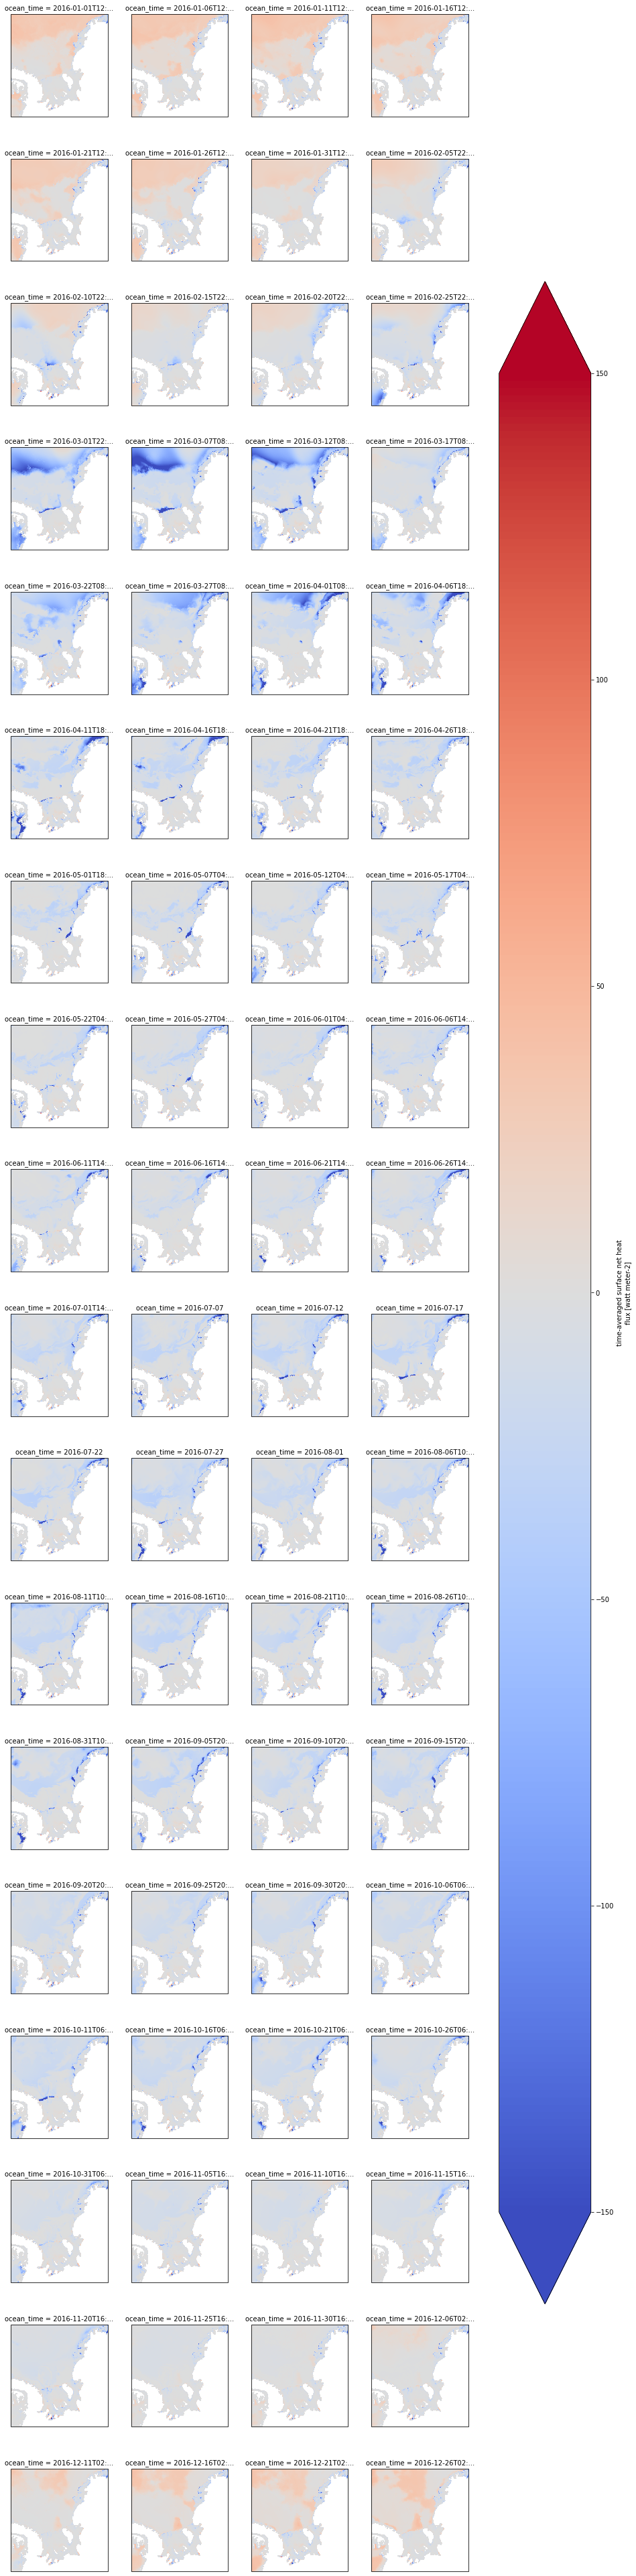

In [5]:
# This is the map projection we want to plot *onto*
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
sh = ds.shflux.isel(ocean_time=[*range(0, 72, 1)],xi_rho=slice(230, 750),eta_rho=slice(750,1300))

p = sh.plot(transform=ccrs.PlateCarree(),  # the data's projection
              x="lon_rho", y="lat_rho",col='ocean_time',col_wrap=4,  
             subplot_kws={'projection': map_proj}, vmin=-150, vmax=150, cmap=cm.get_cmap('coolwarm'))  # the plot's projection

#plt.savefig("shf.png")
plt.show()

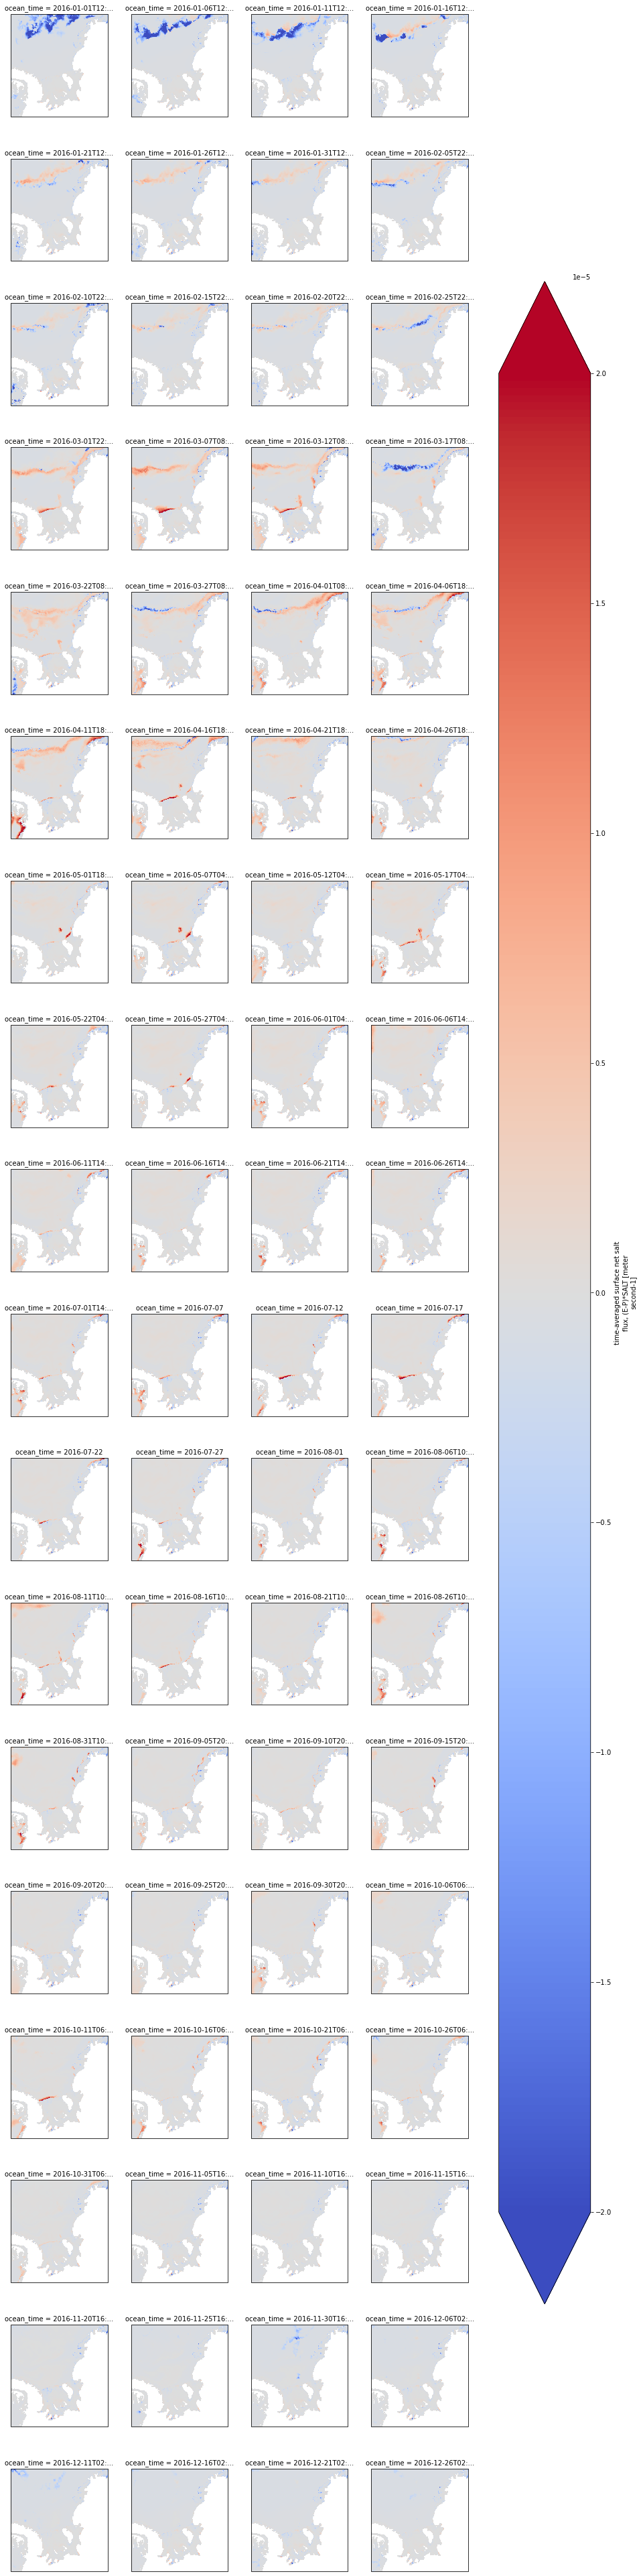

In [6]:
# This is the map projection we want to plot *onto*
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
ss = ds.ssflux.isel(ocean_time=[*range(0, 72, 1)],xi_rho=slice(230, 750),eta_rho=slice(750,1300))

p = ss.plot(transform=ccrs.PlateCarree(),  # the data's projection
              x="lon_rho", y="lat_rho",col='ocean_time',col_wrap=4,  
             subplot_kws={'projection': map_proj}, vmin=-2e-5, vmax=2e-5, cmap=cm.get_cmap('coolwarm'))  # the plot's projection

#plt.savefig("ssf.png")
plt.show()

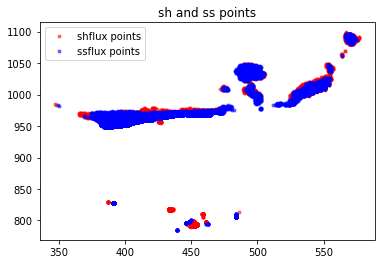

In [7]:
def sh_points(ds,thres,months,xr,yr):
    """
    inputs: the dataset
    thres: the threshold value for flux
    month: the index of desired month
    xr: range of x values to include
    yr: range of y values to include
    
    outputs: the x and y grid locations for the threshold values
    """
    newx = np.array([])
    newy = np.array([])
    for month in months:
        sh_arr = (ds.shflux.values)[month]
        locs = np.where(sh_arr < thres)         # set values above the heat loss threshold to 0

        # filter by area on the map

        for i,j in zip(locs[1],locs[0]):
            if (i>xr[0] and i<xr[1]) and (j>yr[0] and j<yr[1]):
                newx = np.append(i,newx)
                newy = np.append(j,newy)
            
    return newx,newy

def ss_points(ds,thres,months,xr,yr):
    """
    inputs:
        ds: the dataset
        thres: the threshold value for flux
        month: the index of desired month
        xr: range of x values to include
        yr: range of y values to include
    
    outputs: 
        newx, newy: the x and y grid locations for the threshold values
    """
    newx = np.array([])
    newy = np.array([])
    for month in months:
        ss_arr = (ds.ssflux.values)[month]
        locs = np.where(ss_arr > thres)         # set values above the heat loss threshold to 0

        # filter by area on the map
        
        for i,j in zip(locs[1],locs[0]):
            if (i>xr[0] and i<xr[1]) and (j>yr[0] and j<yr[1]):
                newx = np.append(i,newx)
                newy = np.append(j,newy)
    return newx,newy

def mergepoints(x1,y1,x2,y2):
    """
    inputs:
        x1,y1: the x and y coordinates of two arrays
        x2,y2: the x and y coordinates of two arrays
    outputs:
        x,y: the combined arrays of two datapoints
    """
    # create the new set of points
    pts1 = np.empty((0,2))
    pts2 = np.empty((0,2))
    
    # read through each array, create points as tuples
    for i,j in zip(x1,y1):
        l = np.array([i,j])
        pts1 = np.append(np.array([l]),pts1,axis=0)
    for i,j in zip(x2,y2):
        l = np.array([i,j])
        pts2 = np.append(np.array([l]),pts2,axis=0)
        
    # union of the two sets
    set1 = set([tuple(x) for x in pts1])
    set2 = set([tuple(x) for x in pts2])
    pts = np.array([x for x in set1 and set2])
    #     pts2 = np.array([x for x in set1 and set2])
    #     for pt in pts2:
    #         #print(pt)
    #         pts = np.append(np.array([pt]),pts,axis=0)
    
    # separate into x and y arrays again
    x = np.array([])
    y = np.array([])
    for pt in pts:
        x = np.append(pt[0],x)
        y = np.append(pt[1],y)
    
    return x,y
    
#(70, 300),eta_rho=slice(310,650)
xh,yh = sh_points(ds,-120,[*range(0, 72, 1)],[310,750],[750,1100])
xs,ys = ss_points(ds,1e-5,[*range(0, 72, 1)],[310,750],[750,1100])
plt.plot(xh,yh,'.',color="r",alpha=0.5,label='shflux points')
plt.plot(xs,ys,'.',color="b",alpha=0.5,label='ssflux points')
plt.title("sh and ss points")
plt.legend()

2573


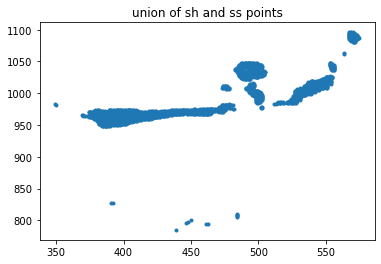

In [8]:
x,y = mergepoints(xh,yh,xs,ys)
plt.plot(x,y,'.')
plt.title("union of sh and ss points")
print(len(x))

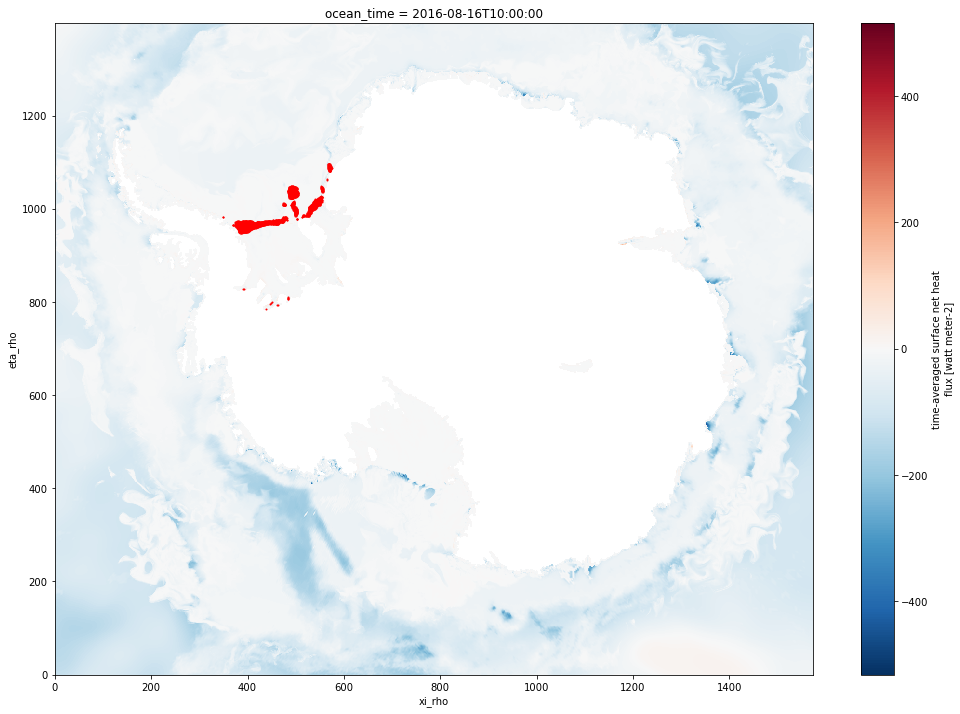

In [9]:
# THESE ARE IN GRID POINTS
fig = plt.figure(figsize=(17,12))
ds.shflux.isel(ocean_time=45).plot()
#plt.coastlines()
plt.plot(x,y,'.',markersize=2, color='r')
plt.savefig("sh_120_ss_1e5_cropped.png")
plt.show()

In [10]:
x_4km = x*2.5
y_4km = y*2.5

In [11]:
# write the above to a text file
firstline = 'POS = G, C, T, N,   Ft0,    Fx0,    Fy0,    Fz0,    Fdt,    Fdx,    Fdy,   Fdz'
secline = ''
G = "1"
C = "0"
T = "1"
N = "1"
Ft0 = '0.1d0'

Fz0 = '-1.0d0'
Fdt = '7.0d0'
Fdx = '0.0d0'
Fdy = '0.0d0'
Fdz = '0.0d0'
lines = [firstline, secline]
for i,j in zip(x,y):
    # create the line to add to lines
    line = "\t"+G+"  "+C+"  "+T+"  "+N+"   "+Ft0+"   "+str(i)+"d0   "+str(j)+"d0   "+Fz0+"   "+Fdt+"   "+Fdx+"   "+Fdy+"   "+Fdz
    lines.append(line)
with open('points_weddell.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')
f.close()